In [1]:
#!pip install keras-nlp

In [2]:
# tensorflow version
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras version
from tensorflow import keras
print('keras: %s' % keras.__version__)
import keras_nlp
print('keras_nlp: %s' % keras_nlp.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import os

tensorflow: 2.9.1
keras: 2.9.0
keras_nlp: 0.3.0


In [3]:
! kaggle datasets download -d adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#! unzip flickr8k.zip -d Flickr8k_Dataset

In [5]:
config = {
    'IMG_URL': os.path.join('Flickr8k_Dataset', 'Images'),
    'TEXT_URL': os.path.join('Flickr8k_Dataset', 'captions.txt'),
    'BATCH_SIZE' : 32
}

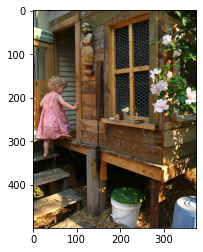

In [6]:
import matplotlib.pyplot as plt

fil = os.path.join(config['IMG_URL'], '1000268201_693b08cb0e.jpg')
ima = Image.open(fil)

plt.imshow(ima)

In [7]:
df = pd.read_csv(config['TEXT_URL']).rename(columns={'image': 'Path', 'caption': 'Description'})

In [8]:
df

,Path,Description
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [9]:
import re

def clean_descriptions(descriptions):
    cleaned = []
    for description in descriptions.split('END'):
        description = description.lower()
        description = re.compile(r'\W*\b\w{1}\b').sub('', description)
        description = description.strip()
        description = '<startseq> ' + description + ' <endseq>'
    
        cleaned.append(description)
    return list(filter(None, cleaned))
    

In [10]:
df['Description'] = df.groupby(['Path'])['Description'].transform(lambda x: 'END'.join(x)).drop_duplicates().transform(clean_descriptions)

In [11]:
#df.head()

In [12]:
df = df.dropna().reset_index(drop=True)

In [13]:
df.head()

,Path,Description
0,1000268201_693b08cb0e.jpg,[<startseq> child in pink dress is climbing up...
1,1001773457_577c3a7d70.jpg,[<startseq> black dog and spotted dog are figh...
2,1002674143_1b742ab4b8.jpg,[<startseq> little girl covered in paint sits ...
3,1003163366_44323f5815.jpg,[<startseq> man lays on bench while his dog si...
4,1007129816_e794419615.jpg,[<startseq> man in an orange hat starring at s...


In [14]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

In [15]:
from functools import reduce
import operator

def get_flattened_descriptions(nested_descriptions):
    return reduce(operator.concat, nested_descriptions)

In [16]:
flat_desc = get_flattened_descriptions(df['Description'].values)

In [17]:
flat_desc[:5]

['<startseq> child in pink dress is climbing up set of stairs in an entry way . <endseq>',
 '<startseq> girl going into wooden building . <endseq>',
 '<startseq> little girl climbing into wooden playhouse . <endseq>',
 '<startseq> little girl climbing the stairs to her playhouse . <endseq>',
 '<startseq> little girl in pink dress going into wooden cabin . <endseq>']

In [18]:
max(flat_desc)

'<startseq> zaftig woman in tube top and jeans dancing outdoors , with guitarist behind her . <endseq>'

In [19]:
max_length = len(max(flat_desc).split(' '))
#max_length = 25

In [20]:
train_df

,Path,Description
7968,848293676_98e73c52c1.jpg,[<startseq> boy in red suit jumps into pool . ...
6321,3569284680_44fef444ef.jpg,[<startseq> young boy in red jacket and young ...
6153,3537474810_cf676b3259.jpg,[<startseq> man in blue uniform kicking the so...
994,2097403787_77a154f5b9.jpg,[<startseq> lone person standing on some rocks...
1221,2206594874_5e0087c6b7.jpg,[<startseq> couple sits at cramped table in bu...
...,...,...
3606,2990471798_73c50c76fb.jpg,[<startseq> boy jumps through the air onto som...
5704,3450874870_c4dcf58fb3.jpg,[<startseq> man rides ski lift up mountain . <...
6637,3636543173_15f56515e5.jpg,[<startseq> man has his hands up while standin...
2575,2661294969_1388b4738c.jpg,[<startseq> float representing the times of ha...


In [21]:
test_df['Description'].dtype

dtype('O')

In [22]:
vectorization = keras.layers.TextVectorization(
    output_mode="int",
    output_sequence_length=max_length,
)

vectorization.adapt(flat_desc)

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))


print(df.iloc[1]['Description'][1])
vec = vectorization(df.iloc[1]['Description'][1])
print(vec)

res = ''
for element in vec.numpy():
    res += f'{index_lookup[element]} '
print(res)

<startseq> black dog and tri-colored dog playing with each other on the road . <endseq>
tf.Tensor(
[   2   15    9    8 1560    9   34   10  137   82    6    5  154    3
    0    0    0], shape=(17,), dtype=int64)
startseq black dog and tricolored dog playing with each other on the road endseq    


In [23]:
vocab_size = len(vocab)
vocab_size

8847

In [24]:
def read_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (224, 224))
    return img


def process_input(path, captions):
    return (read_img(path), vectorization(captions)[:-1]), vectorization(captions)[1:]

In [25]:
def load_dataset(image_paths, captions, batch_size=config['BATCH_SIZE']):
    image_paths = [os.path.join(config['IMG_URL'], x) for x in image_paths for i in range(5)]
    captions = get_flattened_descriptions(captions)
        
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
    
    return dataset.map(process_input).batch(batch_size).shuffle(buffer_size=32).prefetch(tf.data.AUTOTUNE)
    

In [26]:
train_set = load_dataset(train_df['Path'].to_list(), train_df['Description'].to_list())
test_set = load_dataset(test_df['Path'].to_list(), test_df['Description'].to_list())

In [27]:
for entry in train_set.take(1):
    print(entry)
    #plt.imshow(entry[0][0][0].numpy().astype('int'))

((<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[1.04290520e+02, 1.07290520e+02, 1.12290520e+02],
         [1.04449677e+02, 1.07449677e+02, 1.12449677e+02],
         [1.09132233e+02, 1.10132233e+02, 1.14132233e+02],
         ...,
         [2.13820667e+01, 2.03820667e+01, 2.53820667e+01],
         [1.18158522e+01, 1.08158522e+01, 1.58158522e+01],
         [5.41355038e+00, 5.63645411e+00, 8.36631203e+00]],

        [[1.03151787e+02, 1.06151787e+02, 1.11151787e+02],
         [1.03151787e+02, 1.06151787e+02, 1.11151787e+02],
         [1.06736610e+02, 1.07736610e+02, 1.11736610e+02],
         ...,
         [2.19635334e+01, 2.09635334e+01, 2.59635334e+01],
         [1.35386581e+01, 1.25386581e+01, 1.75386581e+01],
         [6.85828638e+00, 7.37171412e+00, 1.01015720e+01]],

        [[1.04917412e+02, 1.08452583e+02, 1.11980446e+02],
         [1.04160713e+02, 1.05657486e+02, 1.10635780e+02],
         [1.05513397e+02, 1.06080360e+02, 1.11080360e+02],
         ...,
        

In [28]:
def sequence_to_text(sequence):
    result = []
    for token in sequence.tolist():
        if index_lookup[token] != '':
            result.append(index_lookup[token])
    return result

In [29]:
augmentation_pipeline = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.3),
    keras.layers.RandomZoom(0.3)
])

In [30]:
def define_caption_model(vocab_size, max_length, embed_dim, latent_dims, heads):
    effnet = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    effnet.trainable = False
    effnet_out = effnet.output
    effnet_out = keras.layers.Reshape((-1, effnet_out.shape[-1]))(effnet_out)
    cnn_model = keras.models.Model(effnet.input, effnet_out)

    img_input = keras.layers.Input(shape=(224, 224, 3), name='Img feature input')
    preprocess_image = augmentation_pipeline(img_input)
    
    img_embed = cnn_model(preprocess_image)
    img_embed = keras.layers.Dense(embed_dim)(img_embed)
    img_embed = keras.layers.Dropout(0.3)(img_embed)

    img_encoder_outputs = keras_nlp.layers.TransformerEncoder(intermediate_dim=latent_dims, 
                                                              num_heads=heads)(img_embed)
    
    decoder_inputs = keras.Input(shape=(max_length-1,), name='Decoder inputs')
    encoded_inputs = keras.Input(shape=(49, embed_dim), name='Encoded inputs (image features)')
    x = keras_nlp.layers.TokenAndPositionEmbedding(vocab_size, max_length, embed_dim, mask_zero=True)(decoder_inputs)
    x = keras_nlp.layers.TransformerDecoder(latent_dims, heads, 0.5)(x, encoded_inputs)
    
    decoder_outputs = keras.layers.Dense(vocab_size)(x)
    decoder = keras.Model([decoder_inputs, encoded_inputs], decoder_outputs)
    
    model_outputs = decoder([decoder_inputs, img_encoder_outputs])
    model = keras.Model(inputs=[img_input, decoder_inputs], outputs = model_outputs)    

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
                  metrics=['accuracy', keras_nlp.metrics.Perplexity(from_logits=True)])
    print(model.summary())
    return model


In [31]:
model = define_caption_model(vocab_size=vocab_size, max_length=max_length, embed_dim=256, latent_dims=512, heads=8)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Img feature input (InputLayer)  [(None, 224, 224, 3  0          []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['Img feature input[0][0]']      
                                                                                                  
 model (Functional)             (None, 49, 1280)     5919312     ['sequential[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 49, 256)      327936      ['model[0][0]']            

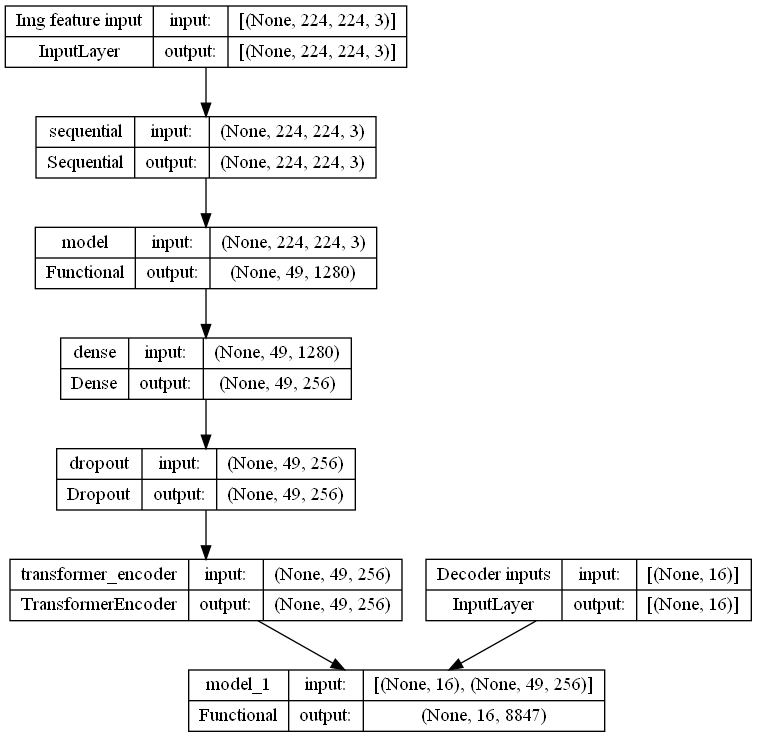

In [32]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [33]:
# fit model
checkpoint = keras.callbacks.ModelCheckpoint('image_caption_generator_model_kerasnlp.h5', save_best_only=True)
reducelr = keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_perplexity')
earlystopping = keras.callbacks.EarlyStopping(patience=10, monitor='val_perplexity')

callbacks = [reducelr, checkpoint, earlystopping]

history = model.fit(train_set, 
          epochs=50, 
          validation_data=(test_set), 
         callbacks=callbacks)

Epoch 1/50
1012/1012 [==============================] - 140s 128ms/step - loss: 2.7899 - accuracy: 0.3055 - perplexity: 57.2673 - val_loss: 2.4141 - val_accuracy: 0.3559 - val_perplexity: 33.2862 - lr: 0.0010
Epoch 2/50
1012/1012 [==============================] - 130s 126ms/step - loss: 2.2669 - accuracy: 0.3574 - perplexity: 26.8152 - val_loss: 2.3536 - val_accuracy: 0.3655 - val_perplexity: 30.4762 - lr: 0.0010
Epoch 3/50
1012/1012 [==============================] - 129s 125ms/step - loss: 2.0979 - accuracy: 0.3728 - perplexity: 20.9823 - val_loss: 2.3180 - val_accuracy: 0.3737 - val_perplexity: 28.9352 - lr: 0.0010
Epoch 4/50
1012/1012 [==============================] - 130s 126ms/step - loss: 1.9898 - accuracy: 0.3834 - perplexity: 17.9371 - val_loss: 2.3145 - val_accuracy: 0.3762 - val_perplexity: 28.7917 - lr: 0.0010
Epoch 5/50
1012/1012 [==============================] - 129s 125ms/step - loss: 1.9184 - accuracy: 0.3909 - perplexity: 16.1705 - val_loss: 2.3184 - val_accuracy: 0

In [34]:
# Load in best weights
# model = keras.models.load_model('image_caption_generator_model_kerasnlp.h5')

In [35]:
model.evaluate(test_set)

253/253 [==============================] - 19s 67ms/step - loss: 2.3292 - accuracy: 0.4058 - perplexity: 29.3738


[2.329197883605957, 0.40577155351638794, 29.373828887939453]

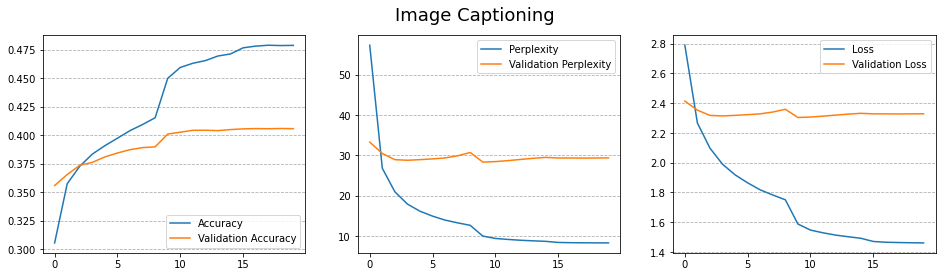

In [36]:
import matplotlib.pyplot as plt

acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
per, val_per = history.history['perplexity'], history.history['val_perplexity']
loss, val_loss = history.history['loss'], history.history['val_loss']
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Image Captioning', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(per, label='Perplexity')
ax[1].plot(val_per, label='Validation Perplexity')
ax[1].grid(axis='y', linestyle='--')

ax[2].plot(loss, label='Loss')
ax[2].plot(val_loss, label='Validation Loss')
ax[2].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [37]:
from pickle import load
from numpy import argmax

def sample_token(logits, k=2):
    logits, indices = tf.math.top_k(logits, k=k, sorted=True)
    indices = np.asarray(indices).astype("int32")
    preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype("float32")
    return np.random.choice(indices[-1,:], p=preds[-1,:])

# generate a description for an image
def generate_desc(model, img, max_length, num_captions=1, k=2):
    if type(img) == 'str':
        img = cv2.imread(img)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, 0)
    
    captions = []    
    for cap in range(num_captions):
        decoded_caption = "<startseq>"
        for i in range(max_length-1):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            predictions = model.predict([img, tokenized_caption], verbose=0)

            sampled_token_index = sample_token(predictions[0:, i, :], k=k)
            sampled_token = index_lookup[sampled_token_index]
            if sampled_token == "endseq":
                break
            decoded_caption += " " + sampled_token

        decoded_caption = decoded_caption.replace('<startseq>', '')
        captions.append(decoded_caption)
    
    return captions

In [38]:
def plot_results(img, description):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    ax.imshow(img)
    ax.text(img.shape[1]+50, img.shape[0]/2-img.shape[0]/2*0.2, 'Caption for image:', fontsize=15, alpha=0.7)
    for index, desc in enumerate(descriptions):
        ax.text(img.shape[1]+50, img.shape[0]/2+(30*index), f'{index+1}. {desc}', fontsize=20)
    
    plt.show()

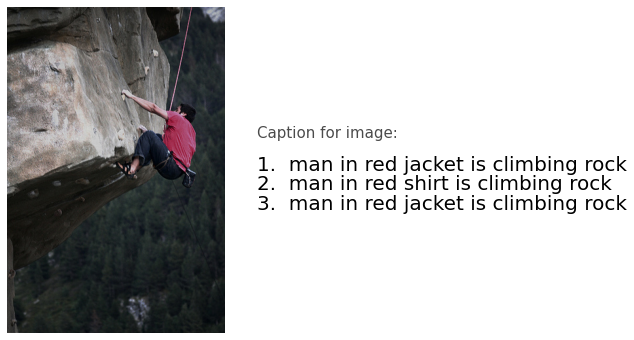

In [39]:
img = cv2.imread(os.path.join(config['IMG_URL'], '997722733_0cb5439472.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
descriptions = generate_desc(model, img, max_length, num_captions=3)
plot_results(img, descriptions)

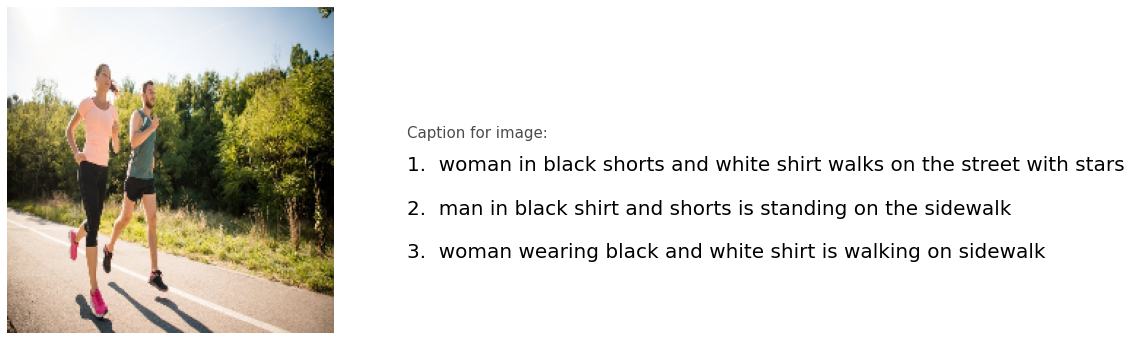

In [40]:
import urllib.request
from tensorflow.keras.preprocessing import image

def url_to_array(url):
    req = urllib.request.urlopen(url)
    arr = np.array(bytearray(req.read()), dtype=np.int8)
    arr = cv2.imdecode(arr, -1)
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    arr = cv2.resize(arr, (224, 224))
    return arr

url = 'https://www.outsideonline.com/wp-content/uploads/2022/01/iStock_89170989_SMALL.jpg'
img = url_to_array(url)

descriptions = generate_desc(model, img, max_length, 3)

plot_results(img, descriptions)

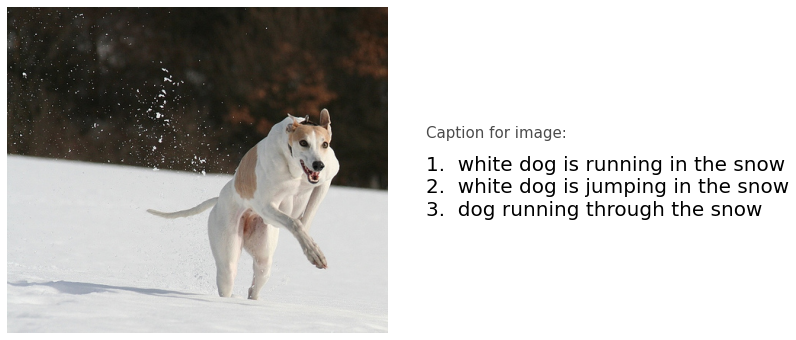

In [41]:
img = cv2.imread(os.path.join(config['IMG_URL'], train_df['Path'][10]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
descriptions = generate_desc(model, img, max_length, 3, 2)
plot_results(img, descriptions)

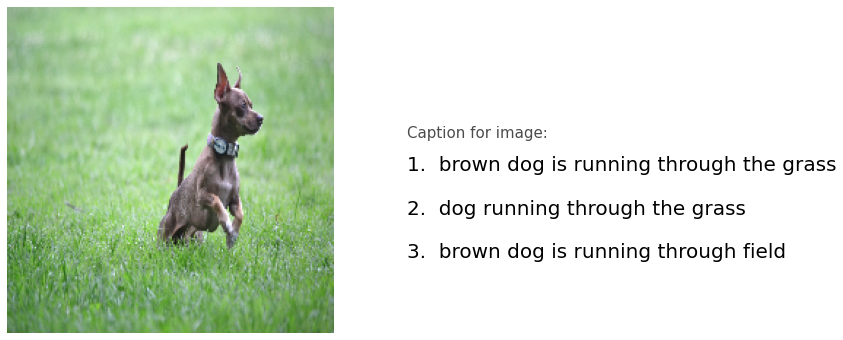

In [42]:
url = 'https://live.staticflickr.com/5585/14750945968_b19c7d0e0f_b.jpg'
img = url_to_array(url)
descriptions = generate_desc(model, img, max_length, 3)
plot_results(img, descriptions)

In [94]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_model(model, img, true_desc, max_length):
    descriptions = generate_desc(model, img, max_length, k=2, num_captions=5)
    descriptions = [desc.split() for desc in descriptions]
    true_desc = [desc.replace('<startseq>', '').replace('<endseq>', '') for desc in true_desc]
    scores = []
    for e in zip(descriptions, true_desc):
        score = sentence_bleu(e[0], e[1], weights=(1/2, 1/2))
        scores.append(score)
    return np.array(true_desc, dtype=object), np.array(descriptions, dtype=object), np.array(scores, dtype=object)

img = cv2.imread(os.path.join(config['IMG_URL'], train_df['Path'][74]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
desc = train_df['Description'][74]

true, preds, score = evaluate_model(model, img, desc, max_length)

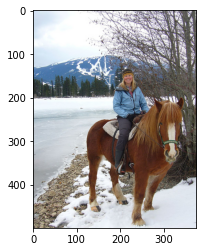

In [95]:
plt.imshow(img)

In [96]:
true

array([' woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain . ',
       ' woman in blue jacket rides brown pony near water . ',
       ' woman rides horse near frozen lake in the wintertime . ',
       ' young blond woman sitting atop brown draft horse in the snowy mountains . ',
       ' woman blue jacket sits on daft horse near frozen lake . '],
      dtype=object)

In [97]:
preds

array([list(['woman', 'with', 'brown', 'hair', 'and', 'blue', 'jacket', 'is', 'riding', 'brown', 'horse']),
       list(['man', 'in', 'blue', 'jacket', 'is', 'riding', 'brown', 'horse', 'on', 'trail', 'in', 'the', 'snow']),
       list(['woman', 'in', 'blue', 'jacket', 'is', 'walking', 'through', 'the', 'snow']),
       list(['man', 'in', 'blue', 'jacket', 'is', 'riding', 'brown', 'horse', 'on', 'snowy', 'ground']),
       list(['man', 'in', 'brown', 'jacket', 'is', 'standing', 'on', 'snowy', 'hill'])],
      dtype=object)

In [98]:
score

array([0.20274167874526933, 0.3495310368212778, 0.20225995873897265,
       0.25468581598680534, 0.23145502494313785], dtype=object)

In [99]:
score.mean()

0.24813470304709256

In [102]:
# Human baseline
sentence_bleu('woman in a blue jacket, on a brown horse, near a frozen lake'.split(), 
              'woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain', 
              weights=(1/2, 1/2))

0.23067585863076587